### Import libraries

In [49]:
from model import classic_model, losses, dot_prod_attention
from data import data_generation, batch_creator, gp_kernels
from keras.callbacks import ModelCheckpoint
from helpers import helpers, masks
from inference import infer
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np
import matplotlib 
import time
import keras

In [50]:
save_dir = '/Users/omernivron/Downloads/GPT'

In [51]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, _, df_te = data_generation.data_generator_for_gp_mimick_gpt(50000, gp_kernels.rbf_kernel)

In [52]:
loss_object = tf.keras.losses.MeanSquaredError()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')
m_tr = tf.keras.metrics.Mean()
m_te = tf.keras.metrics.Mean()

In [53]:
@tf.function
def train_step(decoder, optimizer_c, train_loss, m_tr, pos, tar, pos_mask):
    '''
    A typical train step function for TF2. Elements which we wish to track their gradient
    has to be inside the GradientTape() clause. see (1) https://www.tensorflow.org/guide/migrate 
    (2) https://www.tensorflow.org/tutorials/quickstart/advanced
    ------------------
    Parameters:
    pos (np array): array of positions (x values) - the 1st/2nd output from data_generator_for_gp_mimick_gpt
    tar (np array): array of targets. Notice that if dealing with sequnces, we typically want to have the targets go from 0 to n-1. The 3rd/4th output from data_generator_for_gp_mimick_gpt  
    pos_mask (np array): see description in position_mask function
    ------------------    
    '''
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    combined_mask_tar = masks.create_masks(tar_inp)
    with tf.GradientTape(persistent=True) as tape:
        pred, pred_log_sig = decoder(pos, tar_inp, True, pos_mask, combined_mask_tar)

        loss, mse, mask = losses.loss_function(tar_real, pred, pred_log_sig)

    gradients = tape.gradient(loss, decoder.trainable_variables)
    # Ask the optimizer to apply the processed gradients.
    optimizer_c.apply_gradients(zip(gradients, decoder.trainable_variables))
    train_loss(loss)
    m_tr.update_state(mse, mask)

In [54]:
@tf.function
def test_step(decoder, test_loss, m_te, pos_te, tar_te, pos_mask_te):
    '''
    
    ---------------
    Parameters:
    pos (np array): array of positions (x values) - the 1st/2nd output from data_generator_for_gp_mimick_gpt
    tar (np array): array of targets. Notice that if dealing with sequnces, we typically want to have the targets go from 0 to n-1. The 3rd/4th output from data_generator_for_gp_mimick_gpt  
    pos_mask_te (np array): see description in position_mask function
    ---------------
    
    '''
    tar_inp_te = tar_te[:, :-1]
    tar_real_te = tar_te[:, 1:]
    combined_mask_tar_te = masks.create_masks(tar_inp_te)
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    pred, pred_log_sig = decoder(pos_te, tar_inp_te, False, pos_mask_te, combined_mask_tar_te)
    t_loss, t_mse, t_mask = losses.loss_function(tar_real_te, pred, pred_log_sig)
    test_loss(t_loss)
    m_te.update_state(t_mse, t_mask)

In [55]:
tf.keras.backend.set_floatx('float64')

In [ ]:
if __name__ == '__main__':
    writer = tf.summary.create_file_writer(save_dir + '/logs/')
    optimizer_c = tf.keras.optimizers.Adam()
    decoder = classic_model.Decoder(16)
    EPOCHS = 10
    batch_s  = 128
    run = 0; step = 0
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
    tf.random.set_seed(1)   
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    main_folder = "/Users/omernivron/Downloads/GPT/ckpt/check_"
    folder = main_folder + str(run); helpers.mkdir(folder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    
    with writer.as_default():
        for epoch in range(EPOCHS):
            start = time.time()

            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                m_te.reset_states(); test_loss.reset_states()
                batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr)
                # batch_tar_tr shape := 128 X 59 = (batch_size, max_seq_len)
                # batch_pos_tr shape := 128 X 59 = (batch_size, max_seq_len)
                batch_pos_mask = masks.position_mask(batch_pos_tr)
                train_step(decoder, optimizer_c, train_loss, m_tr, batch_pos_tr, batch_tar_tr, batch_pos_mask)

                if batch_n % 50 == 0:
                    batch_pos_te, batch_tar_te, _ = batch_creator.create_batch_gp_mim_2(pad_pos_te, pad_y_fren_te)
                    batch_pos_mask_te = masks.position_mask(batch_pos_te)
                    test_step(decoder, test_loss, m_te, batch_pos_te, batch_tar_te, batch_pos_mask_te)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Already exists
Restored from /Users/omernivron/Downloads/GPT/ckpt/check_0/ckpt-35
Epoch 0 batch 0 train Loss -1.3306 test Loss -1.6316 with MSE metric 0.0131
Epoch 0 batch 50 train Loss -0.5296 test Loss -1.5464 with MSE metric 0.0316
Epoch 0 batch 100 train Loss -1.4299 test Loss -1.5484 with MSE metric 0.0109
Epoch 0 batch 150 train Loss -1.4530 test Loss -1.5925 with MSE metric 0.0104
Epoch 0 batch 200 train Loss -1.4535 test Loss -1.7037 with MSE metric 0.0104
Epoch 0 batch 250 train Loss -1.5176 test Loss -1.7965 with MSE metric 0.0091
Epoch 0 batch 300 train Loss -1.5456 test Loss -1.8074 with MSE metric 0.0085
Time taken for 1 epoch: 286.8290419578552 secs

Epoch 1 batch 0 train Loss -1.4083 test Loss -1.7742 with MSE metric 0.0111
Epoch 1 batch 50 train Loss -1.5496 test Loss -1.8038 with MSE metric 0.0081
Epoch 1 batch 100 train Loss -1.4873 test Loss -1.9109 with MSE metric 0.0098
Epoch 1 batch 150 train Loss -1.3703 test Loss -1.8881 with MSE metric 0.0121
Epoch 1 batch 200 

In [9]:
x_tr = np.load('/Users/omernivron/Downloads/x_tr.npy')
y_tr = np.load('/Users/omernivron/Downloads/y_tr.npy')

tf.Tensor(-0.008379644863484706, shape=(), dtype=float64)


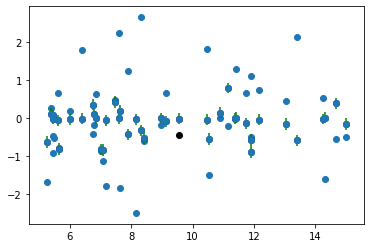

tf.Tensor(0.09038187914316557, shape=(), dtype=float64)


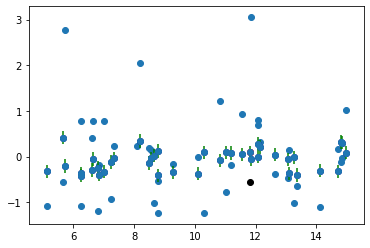

tf.Tensor(0.2689846821156226, shape=(), dtype=float64)


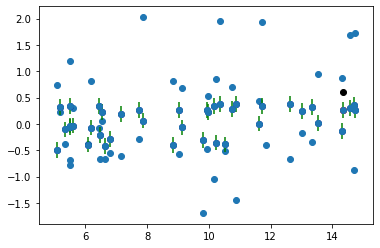

tf.Tensor(0.3281480842554656, shape=(), dtype=float64)


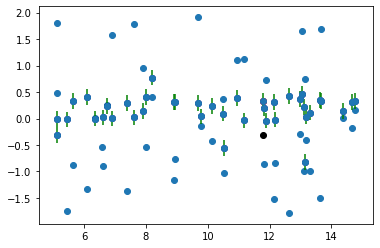

tf.Tensor(-0.30405157089362767, shape=(), dtype=float64)


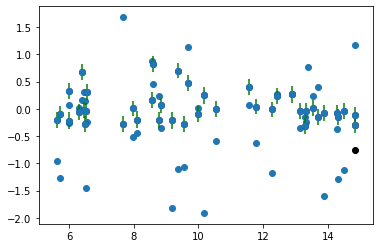

tf.Tensor(0.4416414287438928, shape=(), dtype=float64)


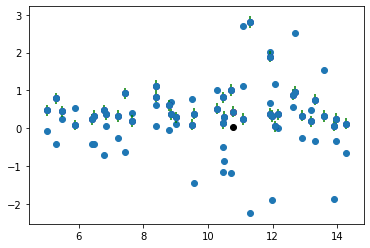

tf.Tensor(-0.0014995691976907727, shape=(), dtype=float64)


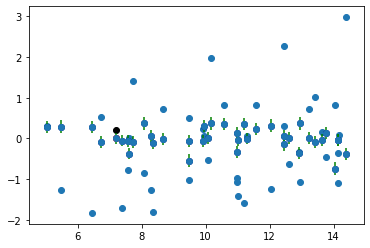

tf.Tensor(0.16522460618082935, shape=(), dtype=float64)


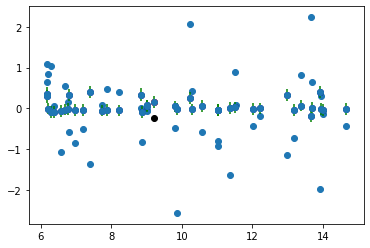

tf.Tensor(0.12801364445968838, shape=(), dtype=float64)


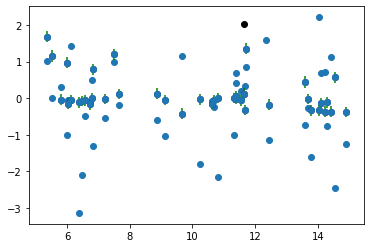

tf.Tensor(0.006535754969316868, shape=(), dtype=float64)


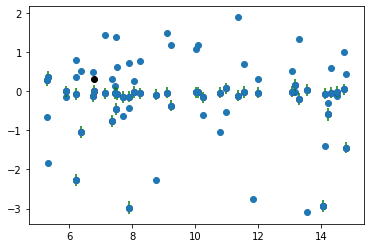

tf.Tensor(-0.09026973792320021, shape=(), dtype=float64)


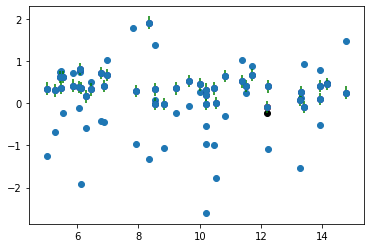

tf.Tensor(0.07359804202711319, shape=(), dtype=float64)


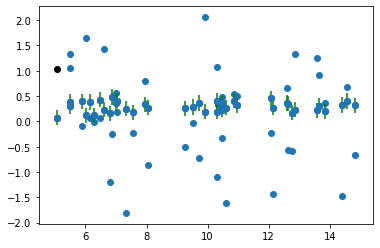

tf.Tensor(-0.240981956352803, shape=(), dtype=float64)


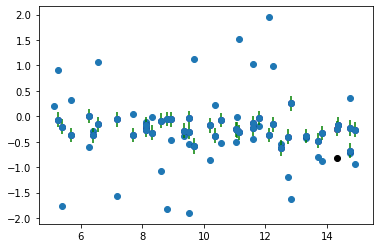

tf.Tensor(-0.035075894243034464, shape=(), dtype=float64)


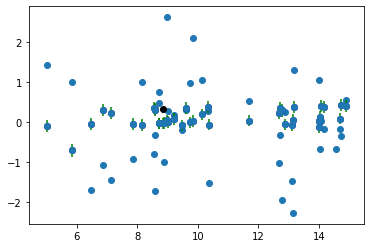

tf.Tensor(0.28479589243343756, shape=(), dtype=float64)


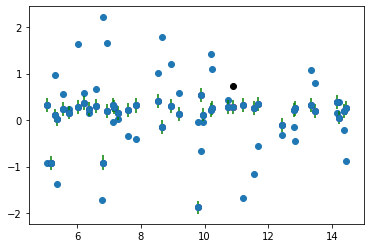

tf.Tensor(0.3493640863527999, shape=(), dtype=float64)


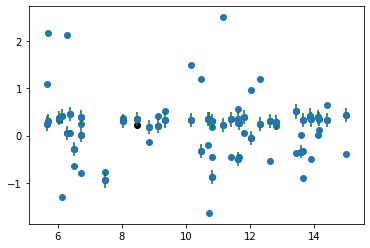

tf.Tensor(-0.0838711117460434, shape=(), dtype=float64)


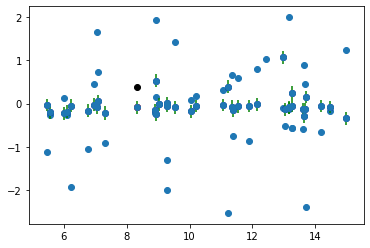

tf.Tensor(0.0014096738907695833, shape=(), dtype=float64)


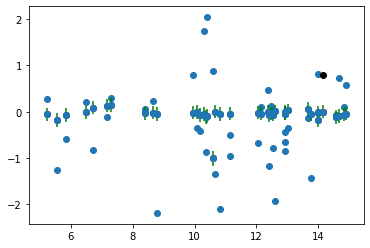

tf.Tensor(0.326195483737373, shape=(), dtype=float64)


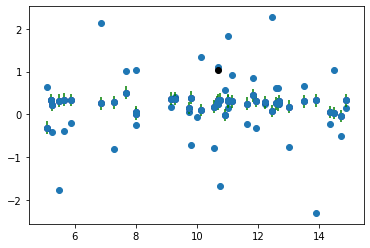

tf.Tensor(0.32763199450734043, shape=(), dtype=float64)


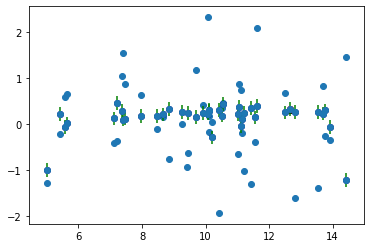

tf.Tensor(0.1342364144615461, shape=(), dtype=float64)


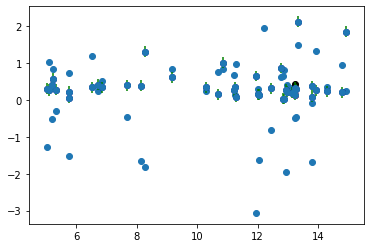

tf.Tensor(-0.05874615814081456, shape=(), dtype=float64)


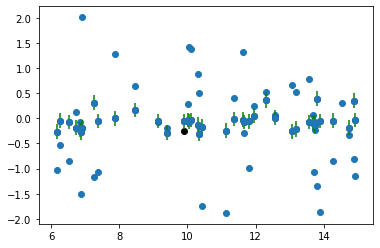

tf.Tensor(-0.03460484440404325, shape=(), dtype=float64)


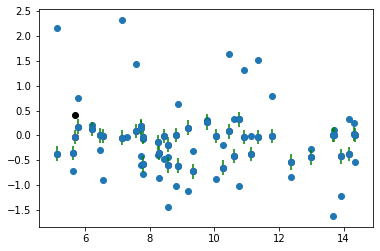

tf.Tensor(-0.30910717980739943, shape=(), dtype=float64)


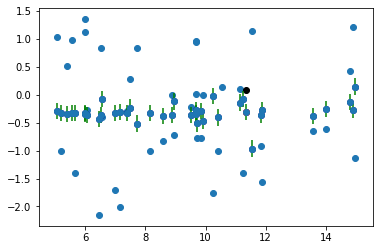

tf.Tensor(0.28718365747005203, shape=(), dtype=float64)


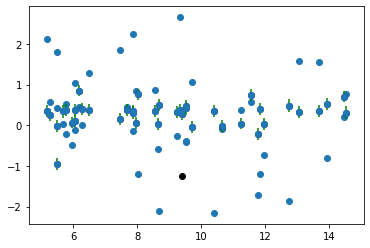

tf.Tensor(0.009140867727336258, shape=(), dtype=float64)


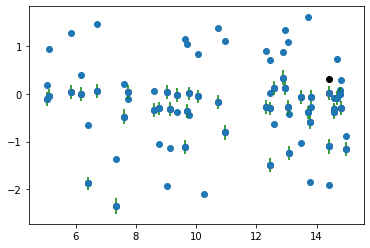

tf.Tensor(0.3666017663505497, shape=(), dtype=float64)


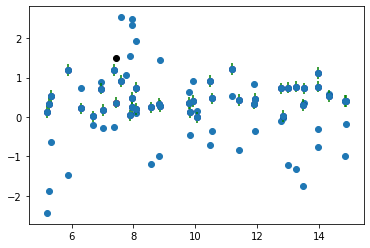

tf.Tensor(0.041572146901874205, shape=(), dtype=float64)


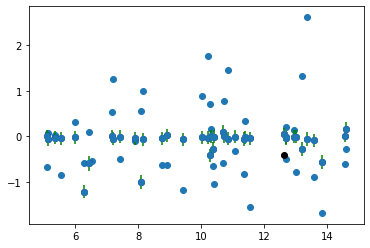

tf.Tensor(-0.024399328757978775, shape=(), dtype=float64)


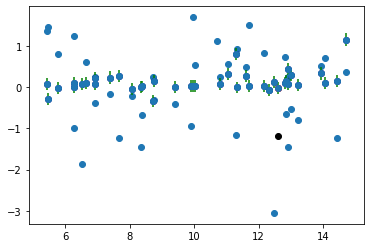

tf.Tensor(0.11213788954337305, shape=(), dtype=float64)


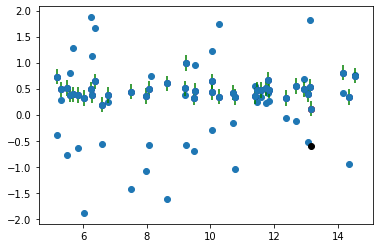

tf.Tensor(-0.007295084890551903, shape=(), dtype=float64)


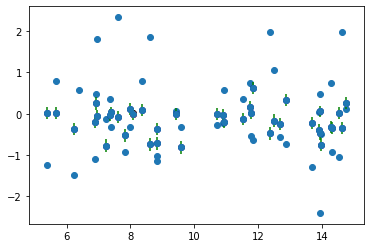

tf.Tensor(0.009580781076812026, shape=(), dtype=float64)


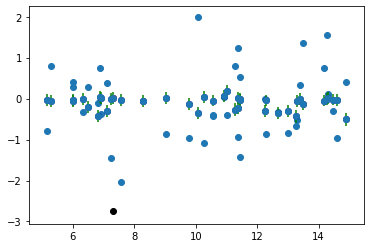

tf.Tensor(0.2825326918585537, shape=(), dtype=float64)


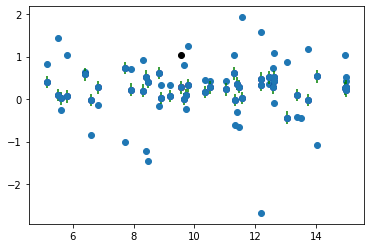

tf.Tensor(0.2769979638125872, shape=(), dtype=float64)


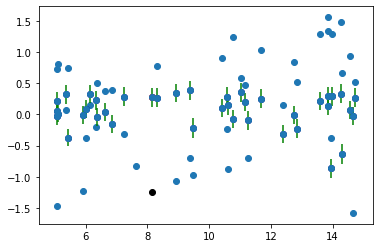

tf.Tensor(-0.2558886472309465, shape=(), dtype=float64)


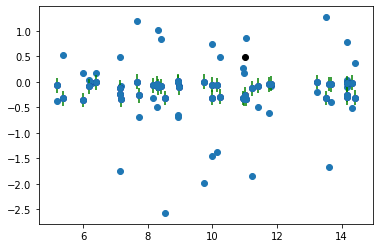

tf.Tensor(0.33976977565197625, shape=(), dtype=float64)


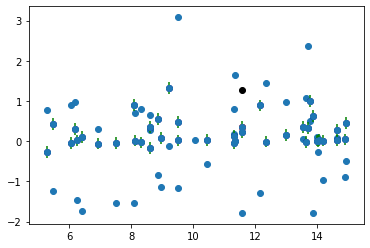

tf.Tensor(-0.03812687338520025, shape=(), dtype=float64)


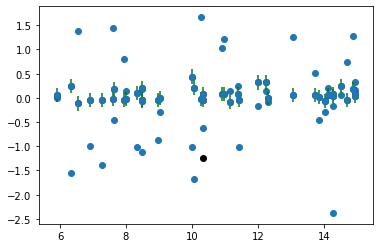

tf.Tensor(-0.06017216990487974, shape=(), dtype=float64)


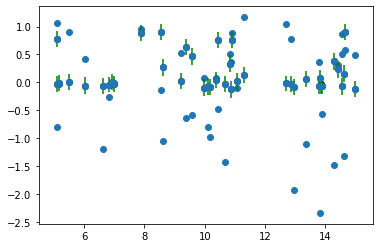

tf.Tensor(-0.3543156492400645, shape=(), dtype=float64)


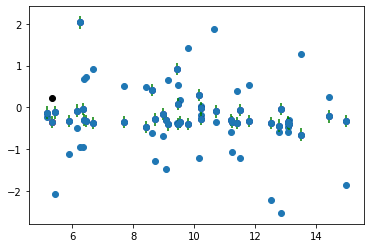

tf.Tensor(-0.31470403164121835, shape=(), dtype=float64)


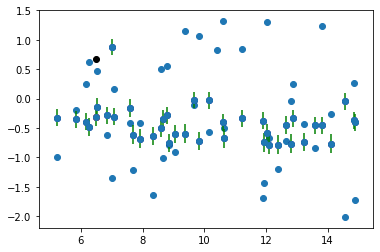

tf.Tensor(0.10294049008152804, shape=(), dtype=float64)


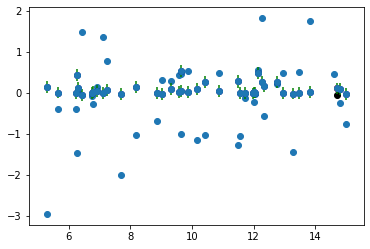

tf.Tensor(0.01667550750881243, shape=(), dtype=float64)


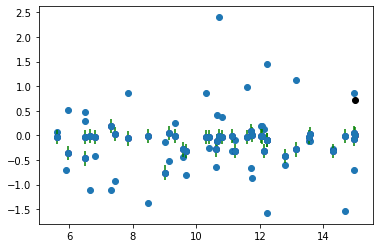

tf.Tensor(0.030017695893368432, shape=(), dtype=float64)


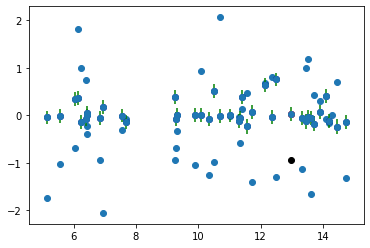

tf.Tensor(0.013075019452707157, shape=(), dtype=float64)


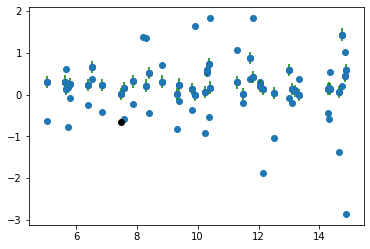

tf.Tensor(-0.3446932460887672, shape=(), dtype=float64)


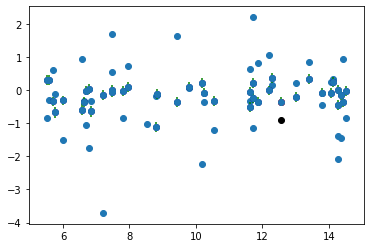

tf.Tensor(0.4081030748609441, shape=(), dtype=float64)


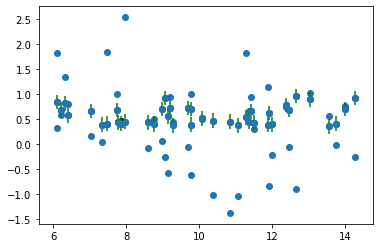

tf.Tensor(0.17239921162231864, shape=(), dtype=float64)


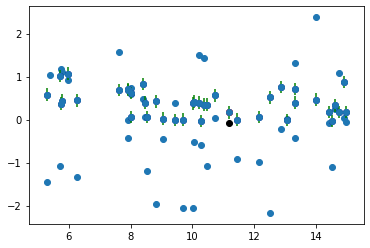

tf.Tensor(0.30999113635912073, shape=(), dtype=float64)


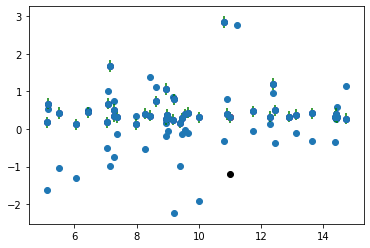

tf.Tensor(0.06322344916917645, shape=(), dtype=float64)


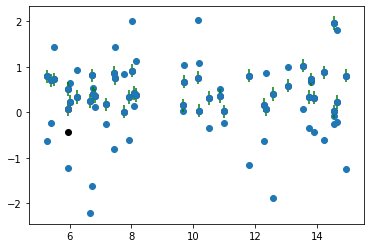

tf.Tensor(-0.001828428038413113, shape=(), dtype=float64)


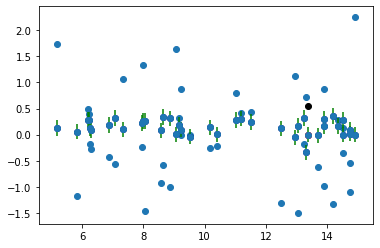

tf.Tensor(0.05813454711321343, shape=(), dtype=float64)


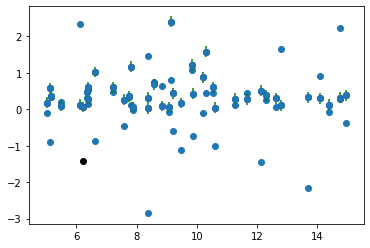

tf.Tensor(0.03559997811042549, shape=(), dtype=float64)


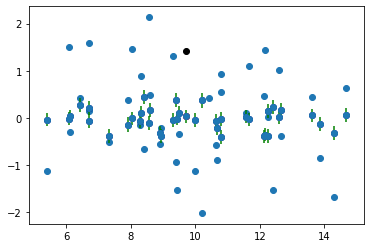

tf.Tensor(-0.005075821213862505, shape=(), dtype=float64)


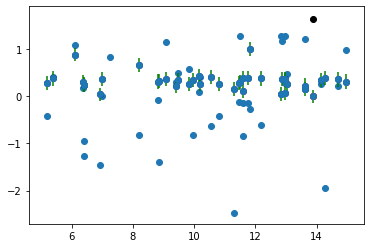

tf.Tensor(-0.004075416669166318, shape=(), dtype=float64)


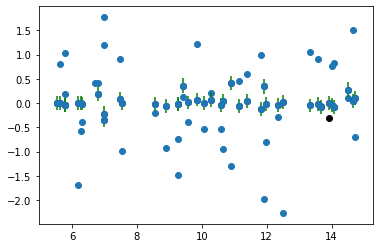

tf.Tensor(-0.0988319973564065, shape=(), dtype=float64)


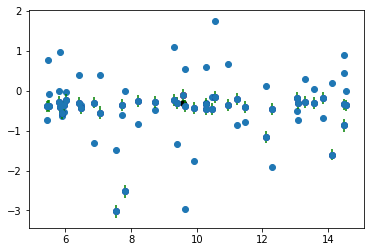

tf.Tensor(-0.0718446831583656, shape=(), dtype=float64)


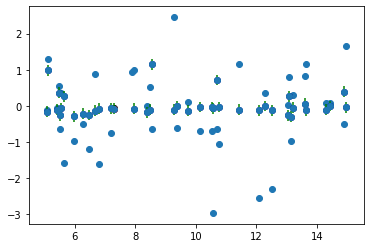

tf.Tensor(-0.02518492419734751, shape=(), dtype=float64)


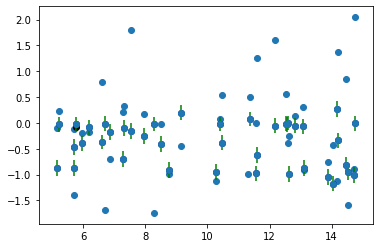

tf.Tensor(0.0703196020176788, shape=(), dtype=float64)


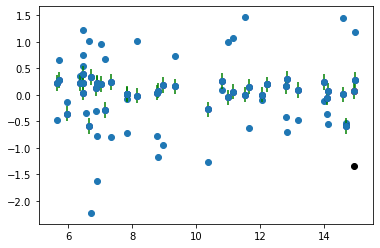

tf.Tensor(0.5026747117183569, shape=(), dtype=float64)


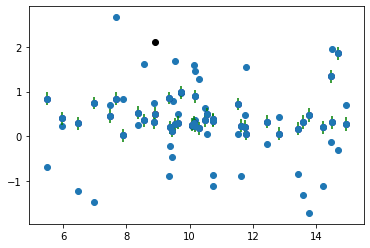

tf.Tensor(-0.02448527300745855, shape=(), dtype=float64)


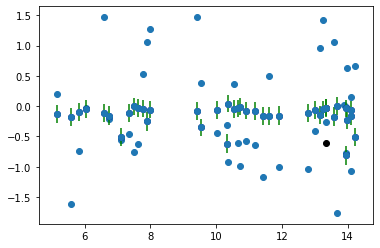

tf.Tensor(0.331820930073023, shape=(), dtype=float64)


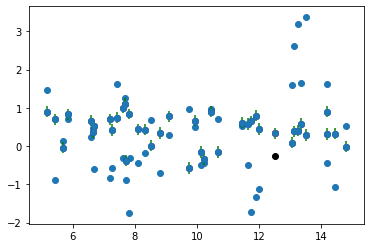

tf.Tensor(0.1622350971745487, shape=(), dtype=float64)


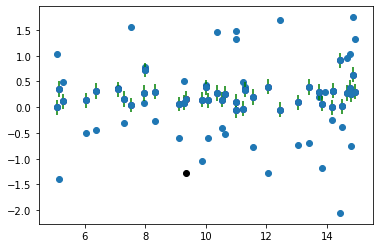

tf.Tensor(-0.06739998819440533, shape=(), dtype=float64)


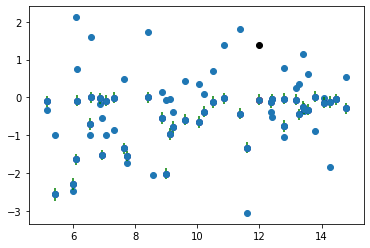

tf.Tensor(0.0505075644247233, shape=(), dtype=float64)


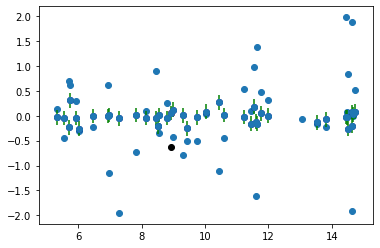

tf.Tensor(-0.07675936499306367, shape=(), dtype=float64)


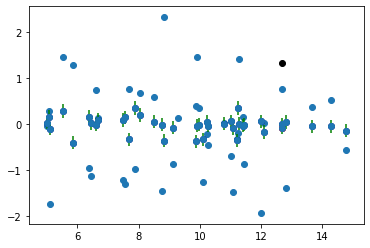

tf.Tensor(-0.1352146912754728, shape=(), dtype=float64)


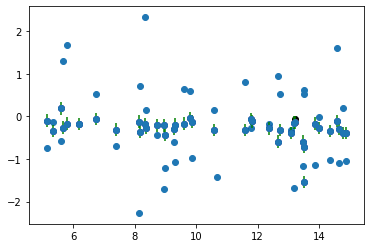

tf.Tensor(-0.024986169300979785, shape=(), dtype=float64)


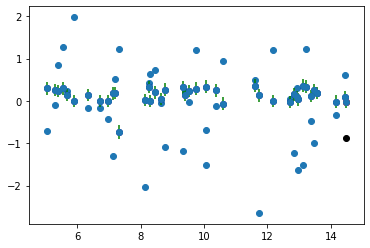

tf.Tensor(0.3612550675802575, shape=(), dtype=float64)


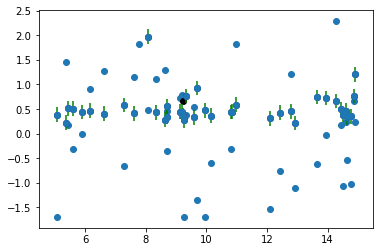

tf.Tensor(0.1655355511833978, shape=(), dtype=float64)


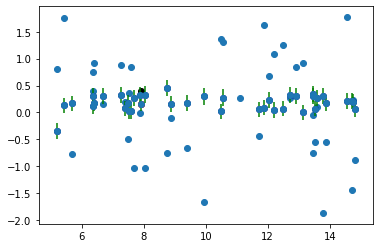

tf.Tensor(0.135164314094406, shape=(), dtype=float64)


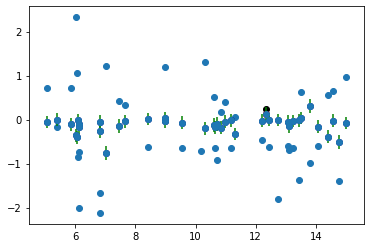

tf.Tensor(0.326882353050293, shape=(), dtype=float64)


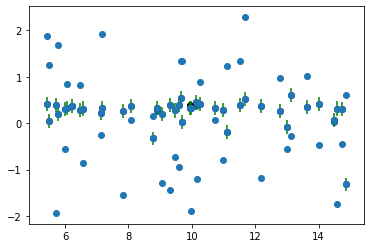

tf.Tensor(0.2126080733282928, shape=(), dtype=float64)


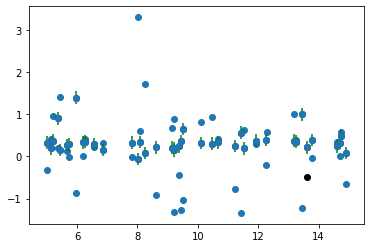

tf.Tensor(0.11529911953270418, shape=(), dtype=float64)


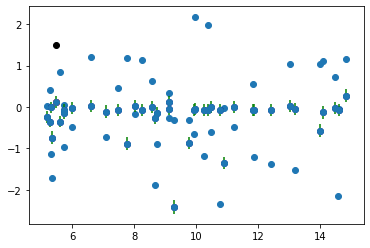

tf.Tensor(0.21822000022975774, shape=(), dtype=float64)


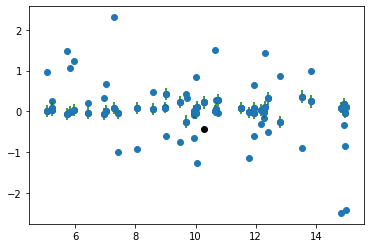

tf.Tensor(0.6663060463208865, shape=(), dtype=float64)


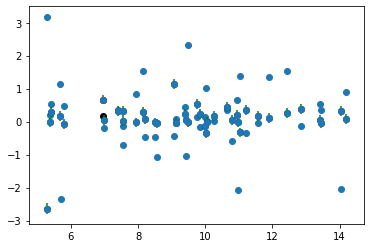

tf.Tensor(0.016036636321600198, shape=(), dtype=float64)


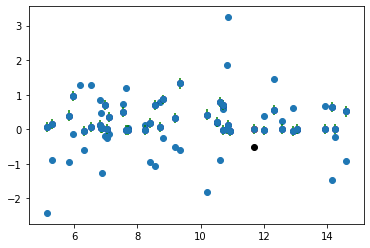

tf.Tensor(0.4563582072554254, shape=(), dtype=float64)


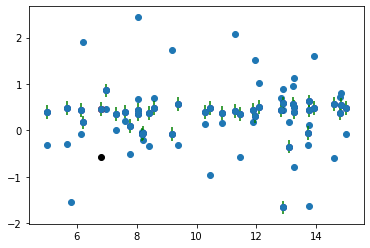

tf.Tensor(0.004931220066595229, shape=(), dtype=float64)


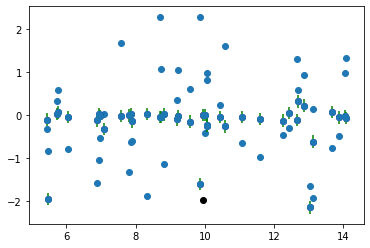

tf.Tensor(0.29294813320248714, shape=(), dtype=float64)


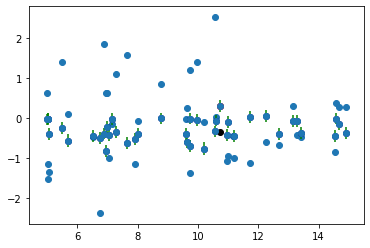

tf.Tensor(0.041061728754730145, shape=(), dtype=float64)


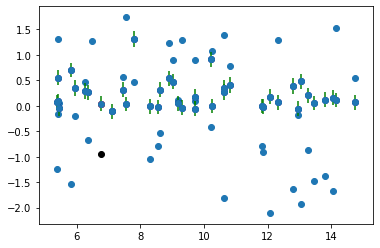

tf.Tensor(0.318851102759836, shape=(), dtype=float64)


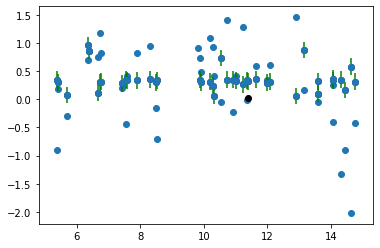

tf.Tensor(0.3408110718872956, shape=(), dtype=float64)


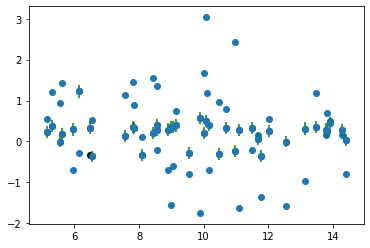

tf.Tensor(-0.019193474887639575, shape=(), dtype=float64)


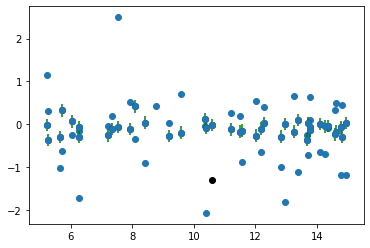

tf.Tensor(0.05801407621204081, shape=(), dtype=float64)


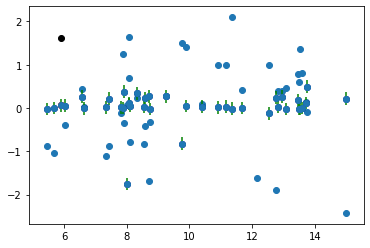

tf.Tensor(-0.06425457656968196, shape=(), dtype=float64)


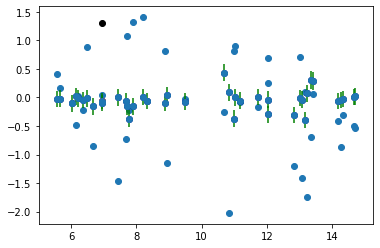

tf.Tensor(0.03328679877501543, shape=(), dtype=float64)


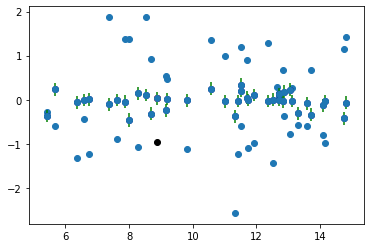

tf.Tensor(0.34191488087661737, shape=(), dtype=float64)


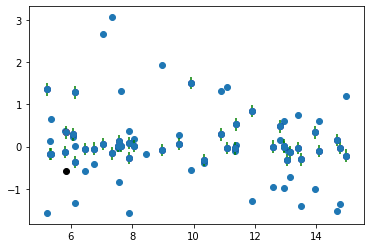

tf.Tensor(0.2968679586538636, shape=(), dtype=float64)


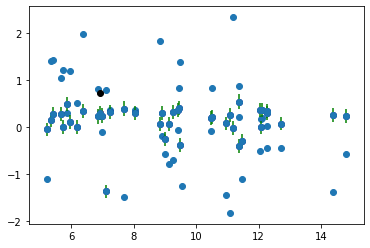

tf.Tensor(0.14540433261204783, shape=(), dtype=float64)


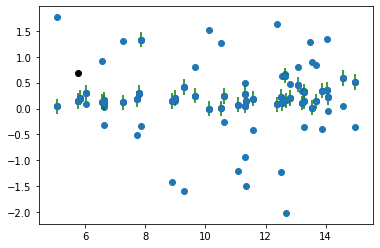

tf.Tensor(0.19903331005947494, shape=(), dtype=float64)


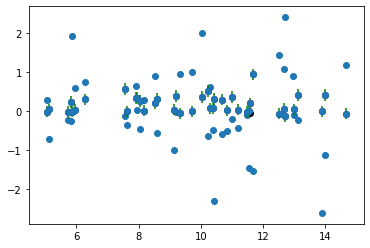

tf.Tensor(0.07218252064307924, shape=(), dtype=float64)


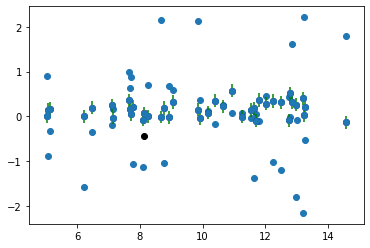

tf.Tensor(0.2787446160838726, shape=(), dtype=float64)


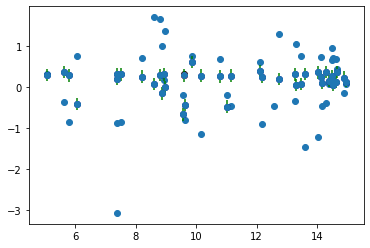

tf.Tensor(0.0033840391066216474, shape=(), dtype=float64)


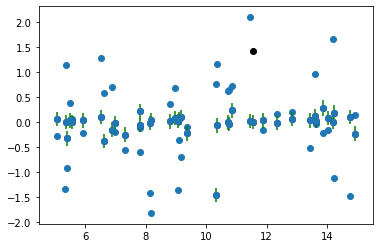

tf.Tensor(0.1355663127562185, shape=(), dtype=float64)


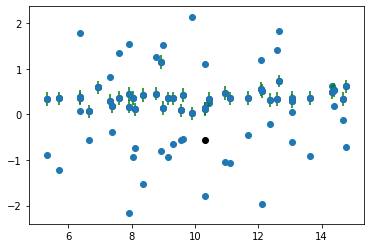

tf.Tensor(0.3126782499602387, shape=(), dtype=float64)


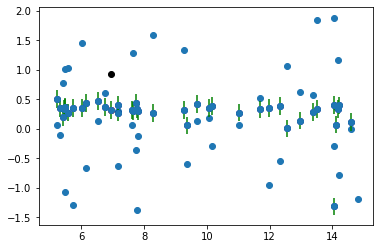

tf.Tensor(0.44421250898390785, shape=(), dtype=float64)


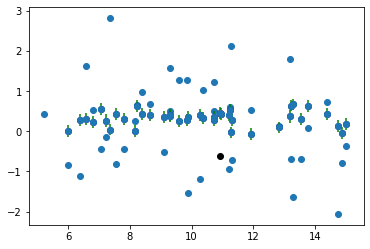

tf.Tensor(0.18508672094598333, shape=(), dtype=float64)


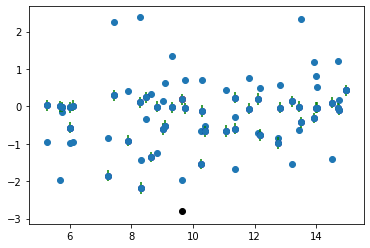

tf.Tensor(0.30390822698101233, shape=(), dtype=float64)


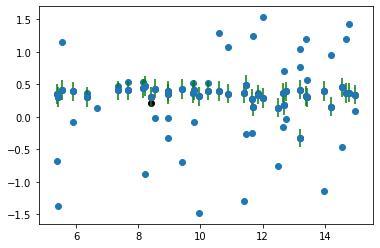

tf.Tensor(0.27618408738353495, shape=(), dtype=float64)


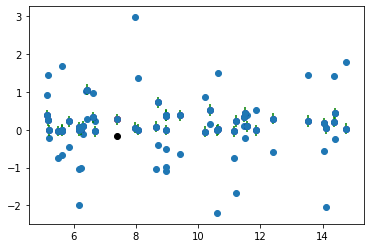

tf.Tensor(-0.09181526628637048, shape=(), dtype=float64)


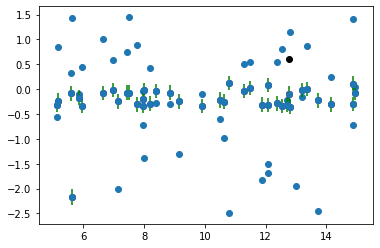

tf.Tensor(0.013061976652393684, shape=(), dtype=float64)


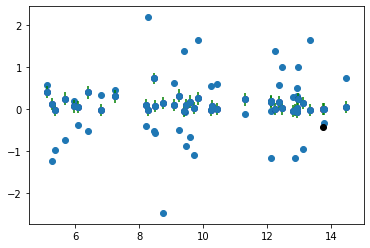

tf.Tensor(-0.037840909382084884, shape=(), dtype=float64)


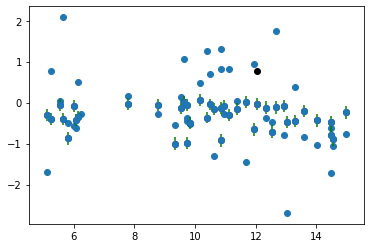

tf.Tensor(-0.010028284218943376, shape=(), dtype=float64)


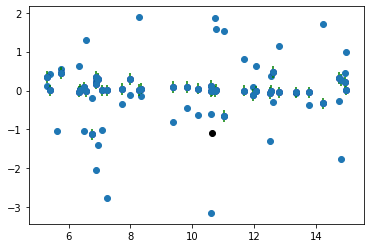

tf.Tensor(0.021109489365312387, shape=(), dtype=float64)


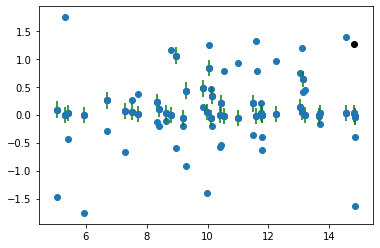

tf.Tensor(0.5387744551478572, shape=(), dtype=float64)


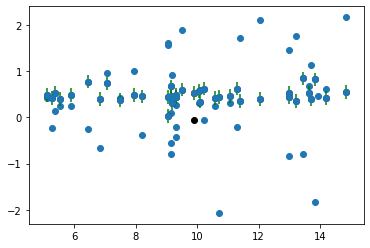

tf.Tensor(0.27861173461376876, shape=(), dtype=float64)


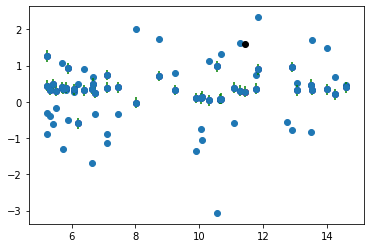

tf.Tensor(0.3539375066515603, shape=(), dtype=float64)


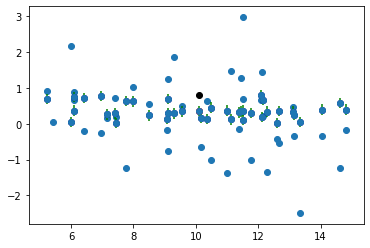

tf.Tensor(0.05972395909151483, shape=(), dtype=float64)


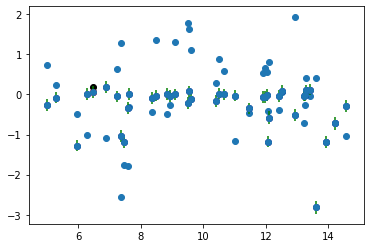

tf.Tensor(0.01959137730466566, shape=(), dtype=float64)


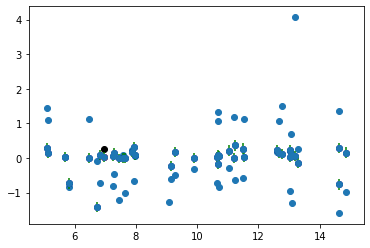

tf.Tensor(0.33958356878657425, shape=(), dtype=float64)


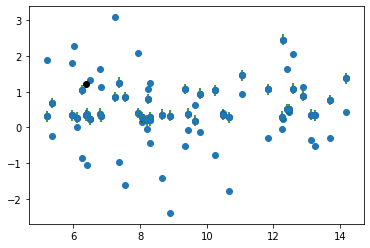

tf.Tensor(0.4391072742677844, shape=(), dtype=float64)


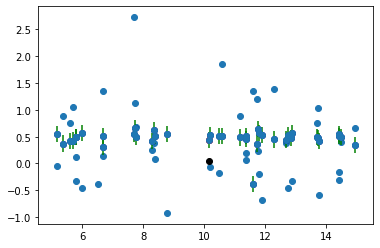

tf.Tensor(0.021612189574628918, shape=(), dtype=float64)


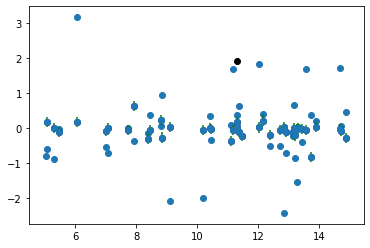

tf.Tensor(0.3537103768084328, shape=(), dtype=float64)


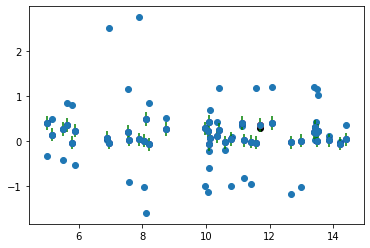

tf.Tensor(0.8419875636430147, shape=(), dtype=float64)


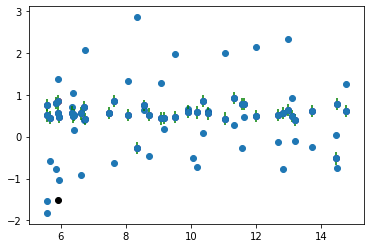

tf.Tensor(-0.08104731428059954, shape=(), dtype=float64)


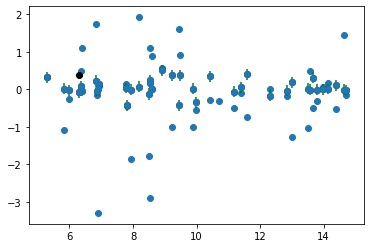

tf.Tensor(-0.004104224539701121, shape=(), dtype=float64)


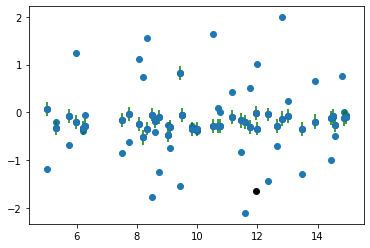

tf.Tensor(0.20538649263865816, shape=(), dtype=float64)


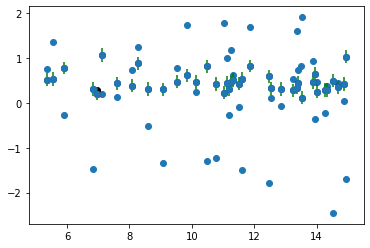

tf.Tensor(-0.23953905219666483, shape=(), dtype=float64)


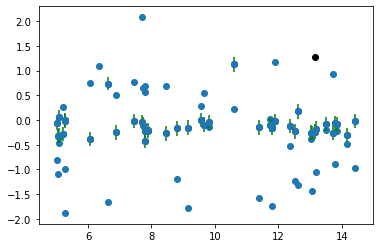

tf.Tensor(-0.0883793467803111, shape=(), dtype=float64)


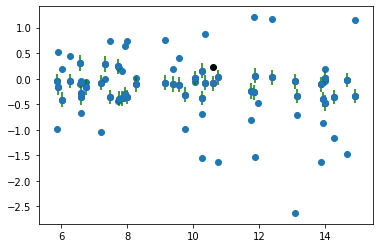

tf.Tensor(-0.006689353831439579, shape=(), dtype=float64)


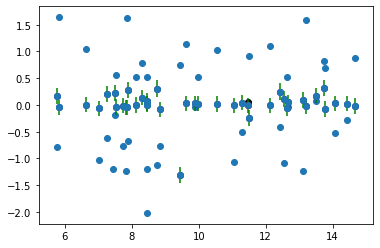

tf.Tensor(-0.027252671633201317, shape=(), dtype=float64)


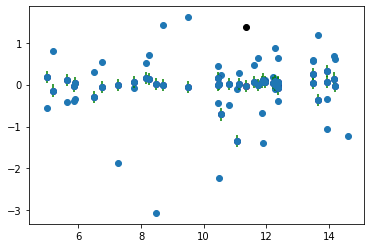

tf.Tensor(0.0007364664928935089, shape=(), dtype=float64)


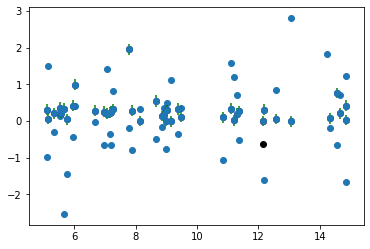

tf.Tensor(0.18448336580601243, shape=(), dtype=float64)


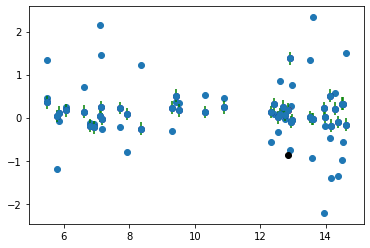

tf.Tensor(0.2114270173580602, shape=(), dtype=float64)


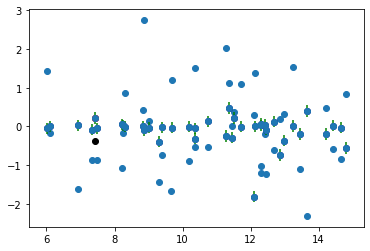

tf.Tensor(-0.03492630100568912, shape=(), dtype=float64)


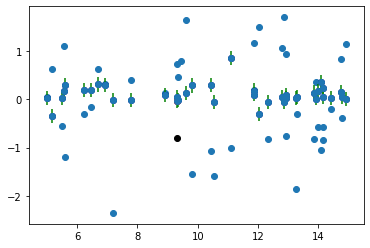

tf.Tensor(0.352160803756264, shape=(), dtype=float64)


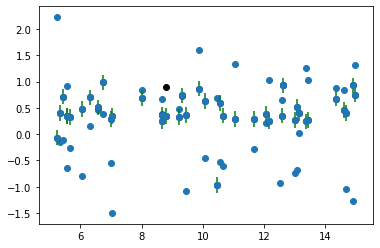

tf.Tensor(0.363409891074682, shape=(), dtype=float64)


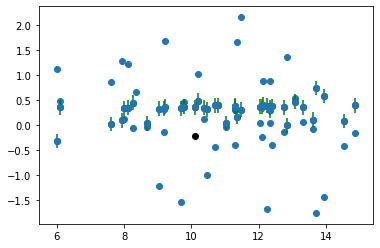

tf.Tensor(0.06007778378646182, shape=(), dtype=float64)


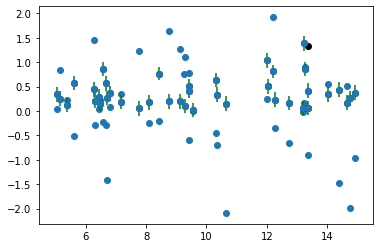

tf.Tensor(0.012681109842359997, shape=(), dtype=float64)


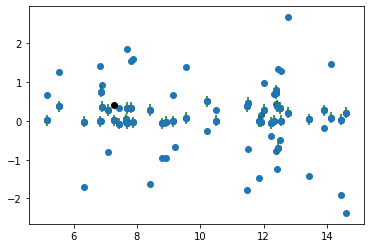

tf.Tensor(-0.04969021978887732, shape=(), dtype=float64)


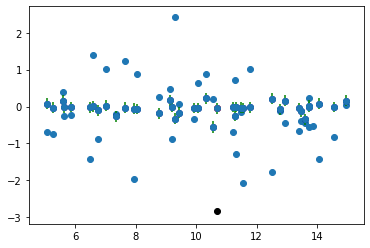

tf.Tensor(0.10472593006048743, shape=(), dtype=float64)


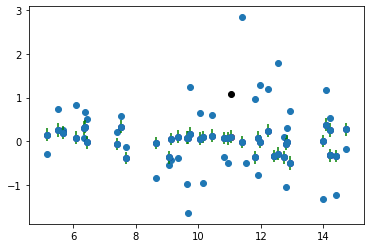

tf.Tensor(0.06007374484380816, shape=(), dtype=float64)


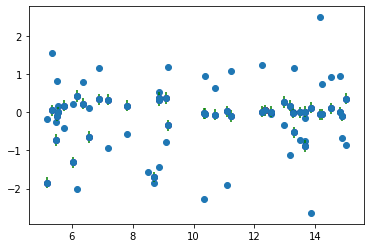

tf.Tensor(-0.00859769785359922, shape=(), dtype=float64)


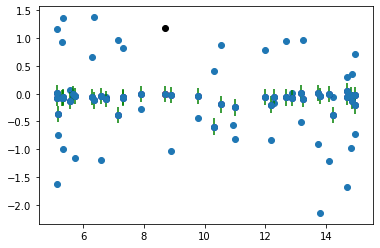

tf.Tensor(0.05668211841797717, shape=(), dtype=float64)


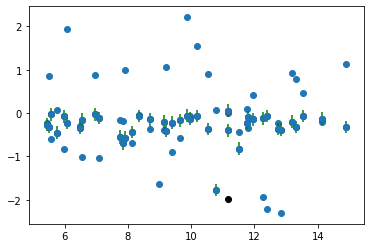

tf.Tensor(-0.07291103047426768, shape=(), dtype=float64)


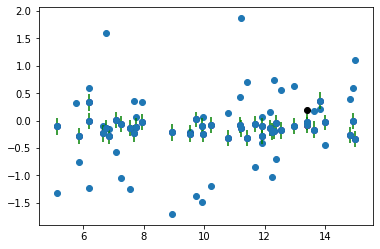

tf.Tensor(-0.018300544781677905, shape=(), dtype=float64)


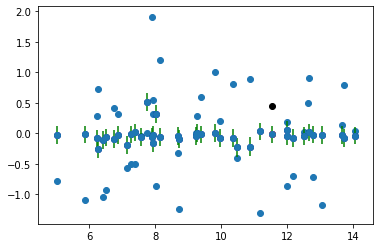

tf.Tensor(-0.014646878767387753, shape=(), dtype=float64)


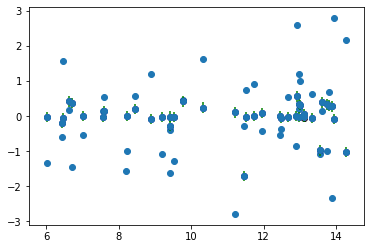

tf.Tensor(0.02843704156898226, shape=(), dtype=float64)


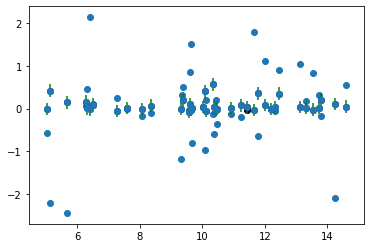

tf.Tensor(0.0505668120915244, shape=(), dtype=float64)


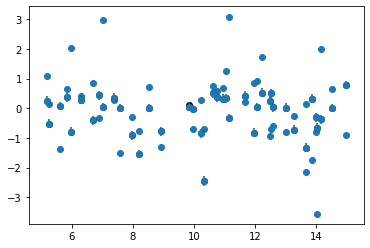

tf.Tensor(-0.08721919569997834, shape=(), dtype=float64)


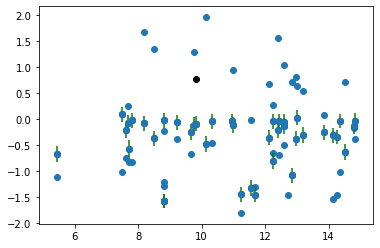

tf.Tensor(0.6235228166629238, shape=(), dtype=float64)


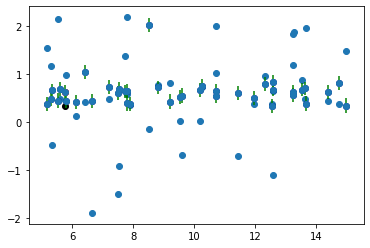

tf.Tensor(0.21830878570529483, shape=(), dtype=float64)


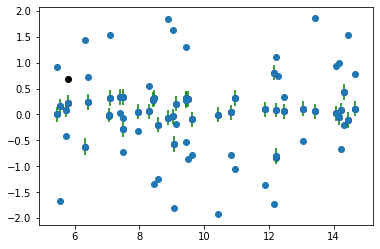

tf.Tensor(-0.07867834419527038, shape=(), dtype=float64)


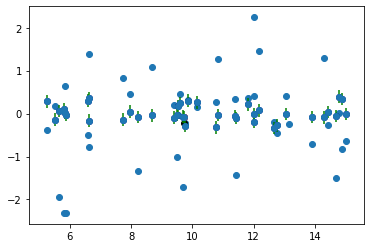

tf.Tensor(-0.3038190827671339, shape=(), dtype=float64)


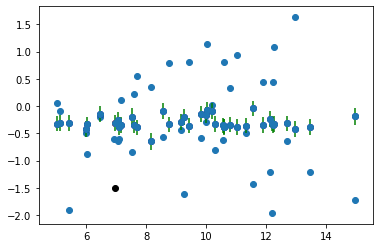

tf.Tensor(-0.03380431592409393, shape=(), dtype=float64)


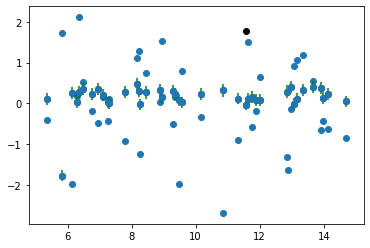

tf.Tensor(0.07678806073657908, shape=(), dtype=float64)


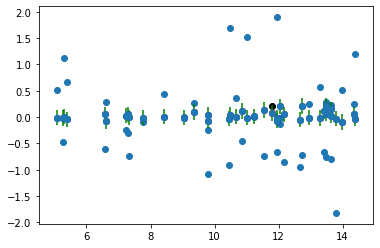

tf.Tensor(-0.004862322824371171, shape=(), dtype=float64)


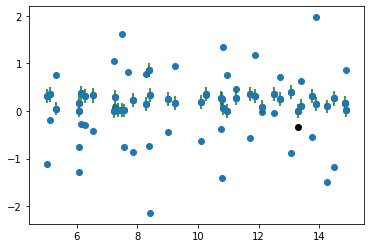

tf.Tensor(-0.10933632382445004, shape=(), dtype=float64)


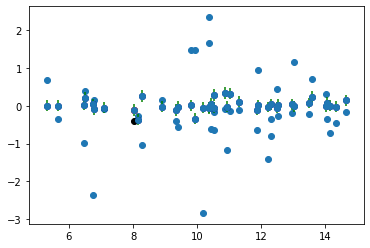

tf.Tensor(-0.1315671740754804, shape=(), dtype=float64)


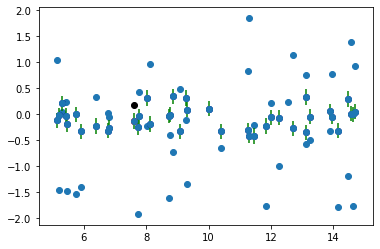

tf.Tensor(0.37314442705368894, shape=(), dtype=float64)


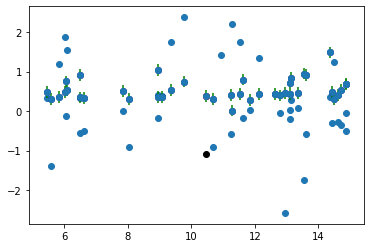

tf.Tensor(-0.04492293154268982, shape=(), dtype=float64)


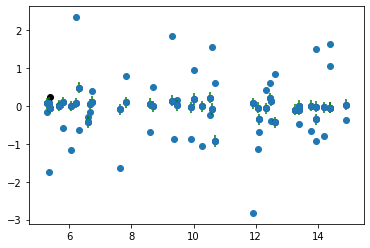

tf.Tensor(-0.21086459139401076, shape=(), dtype=float64)


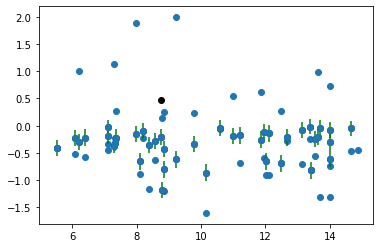

tf.Tensor(0.3322869344998677, shape=(), dtype=float64)


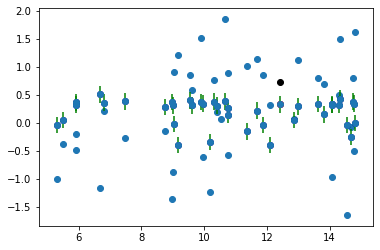

tf.Tensor(0.24376925242483966, shape=(), dtype=float64)


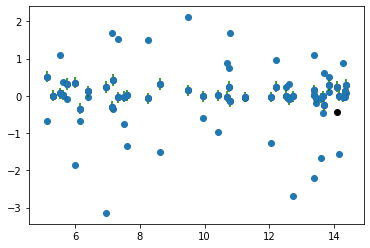

tf.Tensor(0.20012642243553946, shape=(), dtype=float64)


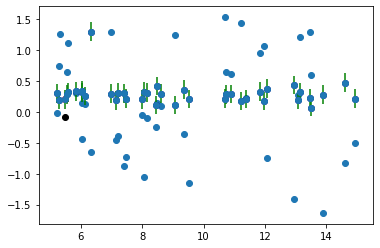

tf.Tensor(0.061439913873075555, shape=(), dtype=float64)


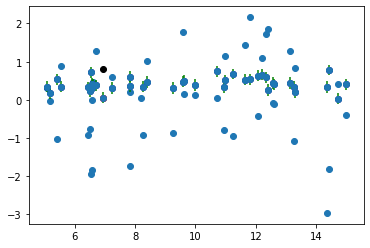

tf.Tensor(0.3319401152308543, shape=(), dtype=float64)


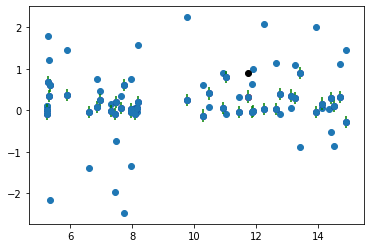

tf.Tensor(0.2650767417138979, shape=(), dtype=float64)


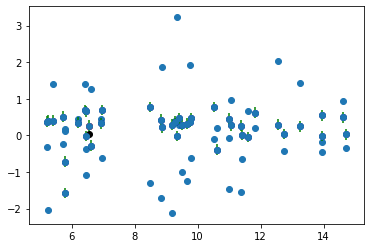

tf.Tensor(0.19977576467239105, shape=(), dtype=float64)


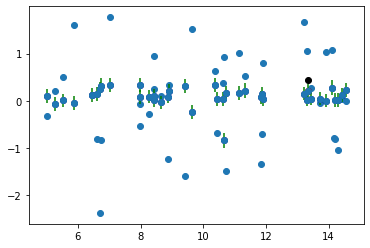

tf.Tensor(-0.006592897465406214, shape=(), dtype=float64)


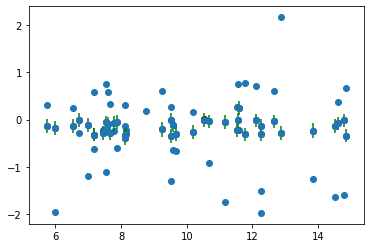

tf.Tensor(-0.1480481757563894, shape=(), dtype=float64)


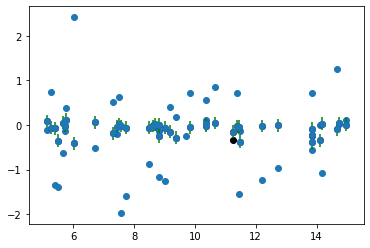

tf.Tensor(0.022075153967214642, shape=(), dtype=float64)


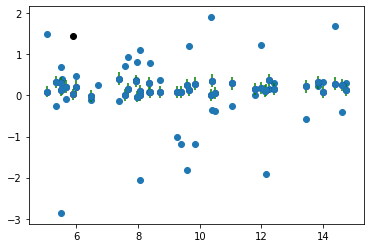

tf.Tensor(0.008084050272570711, shape=(), dtype=float64)


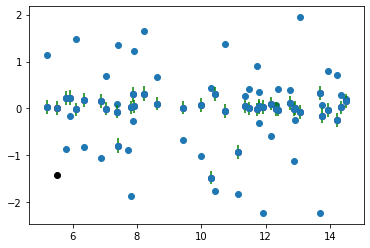

tf.Tensor(0.2832860970914981, shape=(), dtype=float64)


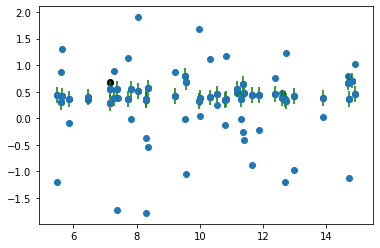

tf.Tensor(0.21237297710868291, shape=(), dtype=float64)


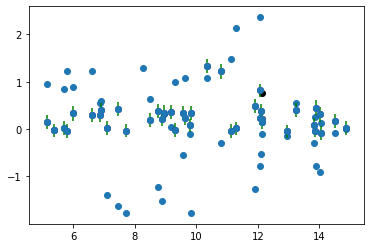

tf.Tensor(-0.03278107515959826, shape=(), dtype=float64)


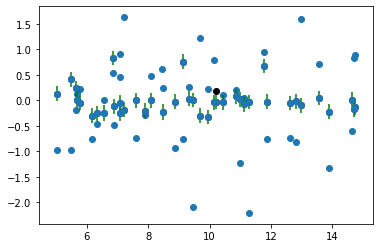

tf.Tensor(0.25748923893042197, shape=(), dtype=float64)


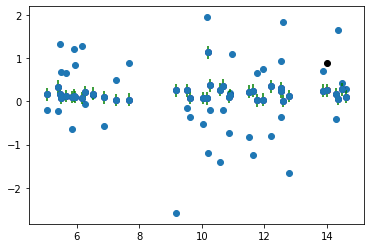

tf.Tensor(0.2795574822917024, shape=(), dtype=float64)


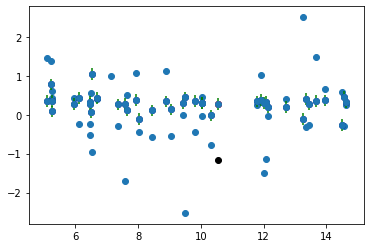

tf.Tensor(0.1604598351384081, shape=(), dtype=float64)


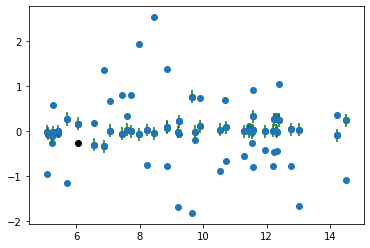

In [45]:
mse = 0 
μ = []; σ = []
m = int(x_tr.shape[0] / 59)
for j in range(0, m):
    xx_tr = x_tr.reshape(-1, 1)[(59 * j):(41 + 59 * j)]
    yy_tr = y_tr.reshape(-1, 1)[(59 * j):(40 + 59 * j)]
    μ_te, log_σ_te = infer.inference(decoder, xx_tr.reshape(1, -1), yy_tr.reshape(1, -1))
    yy_te = y_tr.reshape(-1, 1)[(40 + 59 * j)]
    μ.append(μ_te[-1]); σ.append(log_σ_te[-1])
    mse += (sum((yy_te - μ_te[-1])**2))

    plt.scatter(xx_tr[:-1], yy_tr)
    plt.scatter(xx_tr[1:], μ_te, c='navy')
    plt.scatter(xx_tr[-1], yy_te, c='black')
    plt.scatter(xx_tr[-1], μ_te[-1], c='red')
#     plt.errorbar(x = xx_tr.reshape(-1)[1:], y = tf.squeeze(μ_te), yerr = np.exp(log_σ_te), fmt='o', ecolor='g', capthick=2)
    print(μ_te[-1])
    plt.show()
    
mse *= (1/m) 

In [23]:
mse

<tf.Tensor: shape=(), dtype=float64, numpy=0.8679687705989598>

In [22]:
np.mean(np.exp(σ))

0.14667968028348005